<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/Test_of_QRS_detection_CNN%2BLSTM_70sample_1signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
#or
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org' '/content/physionet.org'

In [5]:
!pip install wfdb numpy scipy matplotlib scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# Gloabla variables

In [1]:
G_window_size = 70
G_overlap = 65
G_fs = 360
G_q_offset = 33

# Model Test

In [2]:
from tensorflow.keras.models import load_model
# Load the model later for inference
model = load_model("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_70sample.h5")

## functions used

In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def bandpass_filter(data, fs, lowcut=0.5, highcut=40.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, data)
    return filtered

def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)


In [4]:
def segment_signal(signal, window_size=50, overlap=40):
    """
    Segment the signal into fixed-length windows with a specified overlap.

    Args:
        signal (np.array): The input signal.
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        tuple: (Array of segmented windows, Array of segment start indices)
    """
    segments = []
    segment_indices = []

    step = window_size - overlap  # Step size for sliding window
    for start in range(0, len(signal) - window_size + 1, step):
        end = start + window_size
        segments.append(signal[start:end])
        segment_indices.append(start)  # Store segment start position

    return np.array(segments), np.array(segment_indices)


## Testing

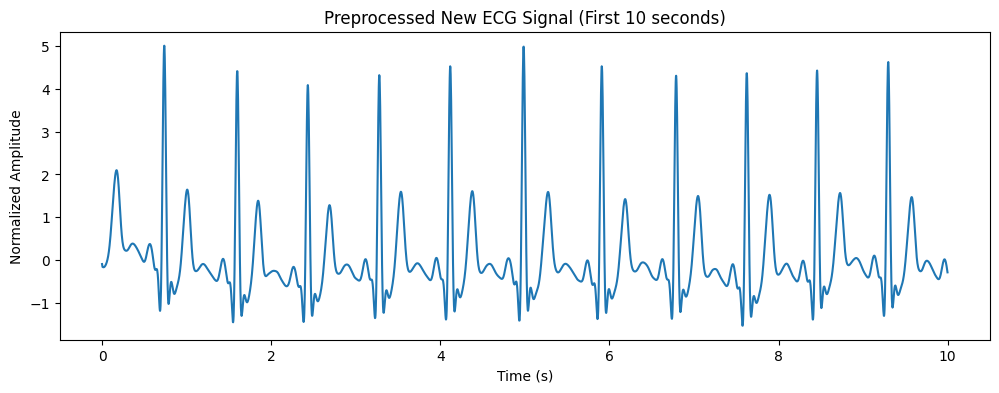

In [48]:
import wfdb
record_dir='/content/physionet.org/files/mitdb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='103'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
new_annotation = wfdb.rdann(new_record_name, 'atr')
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Apply bandpass filter
new_filtered_signal = bandpass_filter(new_ecg_signal, 1000)
# Optionally smooth the signal
new_smoothed_signal = smooth_signal(new_filtered_signal, window_size=5)
new_normalized_signal = normalize_signal(new_smoothed_signal)


# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()



In [49]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 129987 segments with window size 70 and 65 samples overlap.


In [50]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (129987, 70, 1)


In [51]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


4063/4063 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step
Predicted QRS presence for each segment: [0 0 0 ... 0 0 0]


In [52]:
import numpy as np
import matplotlib.pyplot as plt
def display_segment(normalized_signal,segment_labels,segment_starts,z_start,z_end):
  # Define sampling rate

  # Define zoom window in **seconds**
  zoom_start_sec = z_start   # Start time in seconds
  zoom_end_sec = z_end     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * G_fs  # Convert to sample index
  zoom_end = zoom_end_sec * G_fs      # Convert to sample index

  # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]

  # Identify segment start and end in samples
  positive_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 1]
  negative_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 0]
  print("Number of positive (QRS) segments:", len(positive_windows))
  print("Number of negative (non-QRS) segments:", len(negative_windows))
  # Filter positive and negative windows within the zoom range
  positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
  negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

  # Create time axis in **seconds**
  time_axis = np.arange(len(normalized_signal)) / G_fs  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight positive (QRS) windows in red (only within the zoom range)
  for start, end in positive_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"Positive (QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()

  # Plot 2: Negative (Non-QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight negative (non-QRS) windows in yellow (only within the zoom range)
  for start, end in negative_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows_zoom[0][0] else "")
      #plt.vlines(start / G_fs, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")

  plt.title(f"Negative (Non-QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()


Number of positive (QRS) segments: 13986
Number of negative (non-QRS) segments: 116001


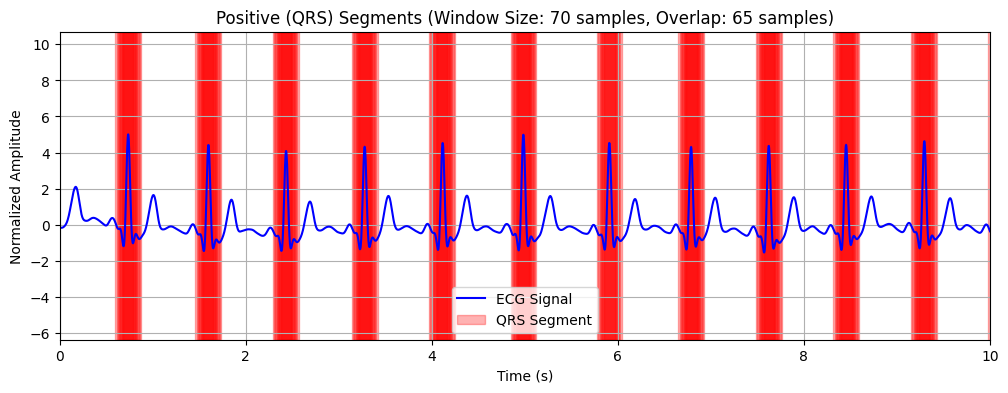

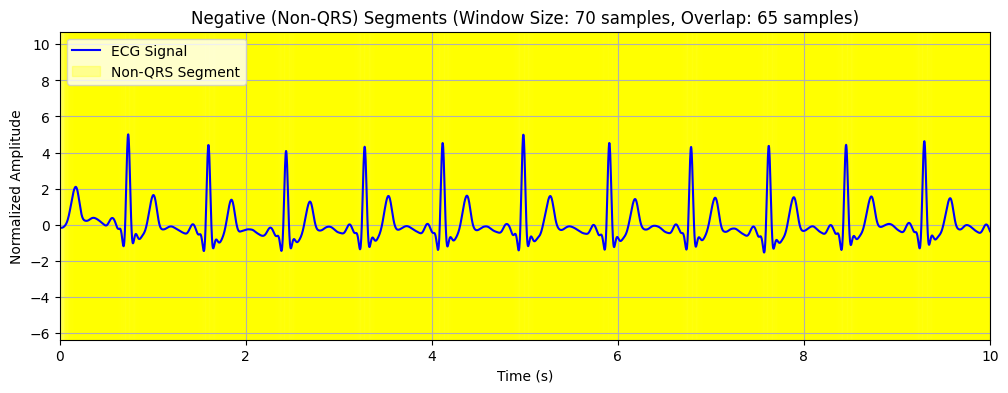

In [53]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of positive (QRS) segments: 13986
Number of negative (non-QRS) segments: 116001


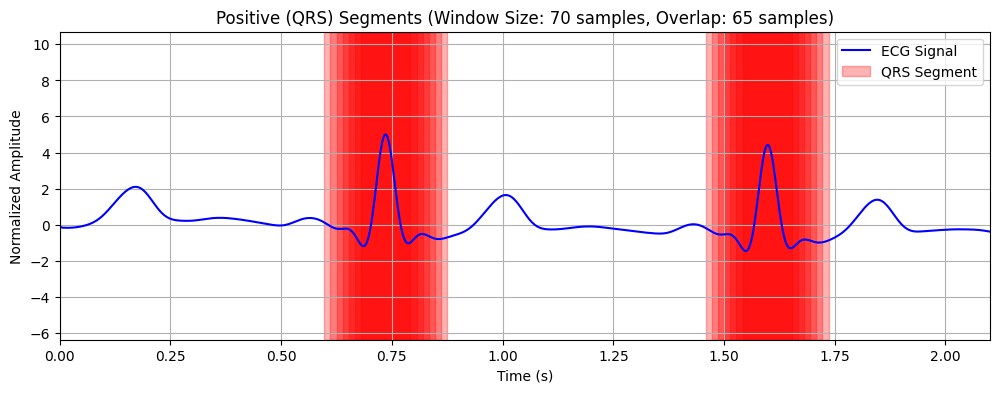

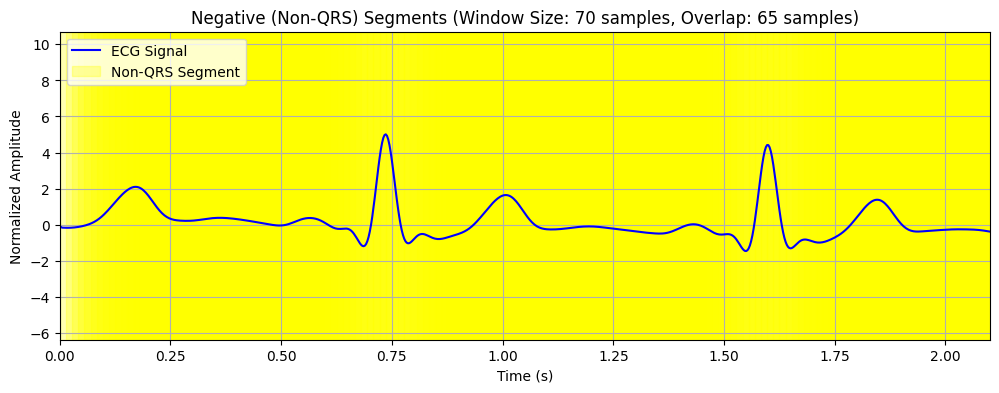

In [54]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

## evaluation

In [12]:

def label_segments(normalized_signal,segments, segment_starts, qrs_indices, q_offset=G_q_offset, window_size=G_window_size, overlap=G_overlap):
    """
    Label each segment as QRS (1) or non-QRS (0), ensuring an equal number of 0 and 1 labels.

    Args:
        segments (np.array): Array of segmented windows.
        segment_starts (np.array): Start indices of segments.
        qrs_indices (list): List of QRS indices (in samples).
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        np.array: Array of labels (1 for QRS, 0 for non-QRS).
    """
    labels = np.zeros(len(segments), dtype=int)

    # Label QRS segments
    for i, segment_start in enumerate(segment_starts):
        segment_end = segment_start + window_size

        # Check if any QRS index falls within this segment
        for r_peak in qrs_indices:
            q_start = r_peak - q_offset  # Approximate Q start
            s_end = r_peak + q_offset    # Approximate S end

            # Ensure q_start and s_end are within bounds
            q_start = max(0, q_start)
            s_end = min(len(normalized_signal) - 1, s_end)

            if segment_start <= q_start and segment_end >= s_end:
                labels[i] = 1
                break

    # Balance the dataset by randomly sampling non-QRS segments
    qrs_count = np.sum(labels == 1)  # Number of QRS segments
    non_qrs_indices = np.where(labels == 0)[0]  # Indices of non-QRS segments

    # Randomly sample non-QRS segments to match the number of QRS segments
    if len(non_qrs_indices) > qrs_count:
        sampled_non_qrs_indices = np.random.choice(non_qrs_indices, size=qrs_count, replace=False)
        labels[sampled_non_qrs_indices] = 0  # Ensure sampled non-QRS segments are labeled as 0
    else:
        print("Warning: Not enough non-QRS segments to balance the dataset.")

    return labels



In [13]:
# Filter the annotation symbols to include only typical QRS types (adjust as needed)
new_qrs_symbols = ['N', 'L', 'R', 'V', 'A']  # Common QRS annotation symbols
new_qrs_indices = [s for s, sym in zip(new_annotation.sample, new_annotation.symbol) if sym in new_qrs_symbols]

# Label the segments using actual segment start positions
# Correct the function call to pass arguments in the correct order
real_labels = label_segments(new_normalized_signal, new_segments, new_start_segments, new_qrs_indices, q_offset=G_q_offset, window_size=G_window_size, overlap=G_overlap)

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,roc_curve, auc



def eval_new_signal(real_labels, predicted_labels):
  # accuracy
  accuracy = (predicted_labels.flatten() == real_labels).mean()
  print(f"Accuracy: {accuracy * 100:.2f}%")
  # classification report
  print(classification_report(real_labels, predicted_labels.flatten()))
  # Confusion Matrix
  cm = confusion_matrix(real_labels, predicted_labels.flatten())

  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-QRS", "QRS"], yticklabels=["Non-QRS", "QRS"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  # Recall
  fpr, tpr, _ = roc_curve(real_labels, predictions.flatten())
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()



Accuracy: 90.84%
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    127903
           1       0.15      1.00      0.26      2084

    accuracy                           0.91    129987
   macro avg       0.57      0.95      0.61    129987
weighted avg       0.99      0.91      0.94    129987



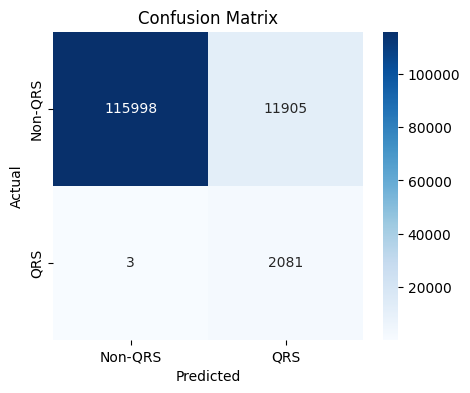

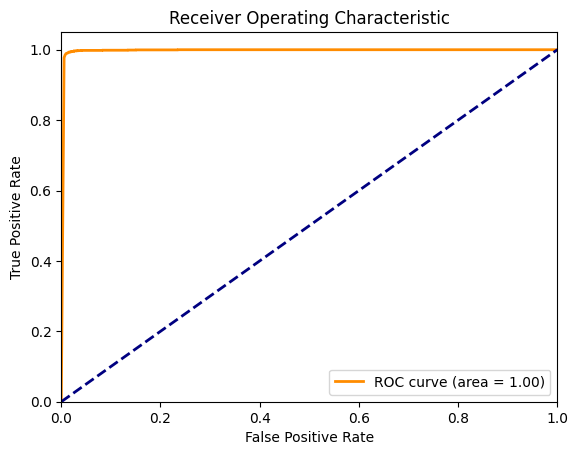

In [15]:
eval_new_signal(real_labels,predicted_labels)

## improvement

In [55]:
def remove_consecutive_ones(segment_labels, segmented_signal, segment_starts):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0
    while i < len(segment_labels)-1:
        if segment_labels[i] == 1:
            # Find the range of consecutive ones
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            # Compute the middle index of the block
            mid = (start + end) // 2

            # Keep only the middle one
            filtered_labels.append(segment_labels[mid])
            filtered_signal.append(segmented_signal[mid])
            filtered_starts.append(segment_starts[mid])

        else:
            # Keep zeros as they are
            filtered_labels.append(segment_labels[i])
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])

        i += 1  # Move to the next segment

    return filtered_labels, filtered_signal, filtered_starts


predicted_labels, new_segments, new_start_segments = remove_consecutive_ones( predicted_labels, new_segments, new_start_segments)

Number of positive (QRS) segments: 2081
Number of negative (non-QRS) segments: 116000


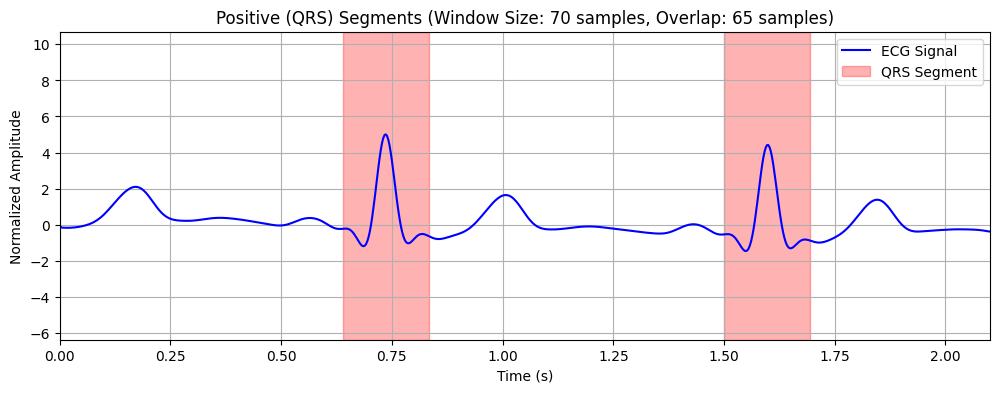

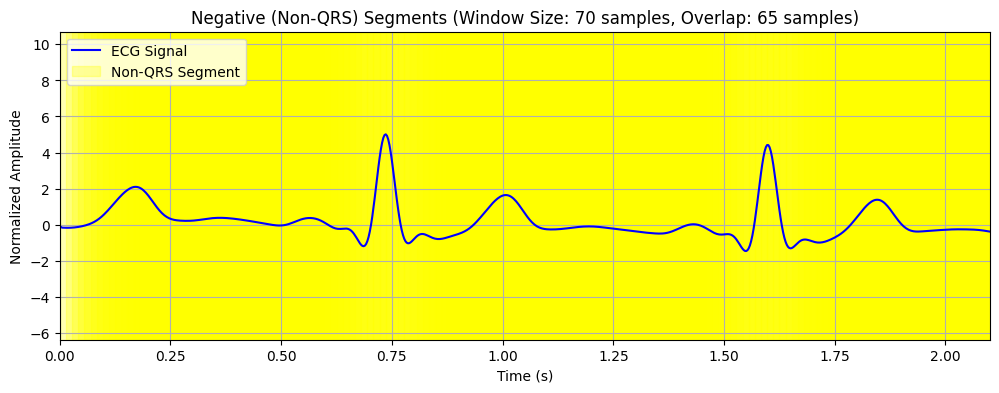

In [56]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

In [57]:
def remove_touching_negatives(segment_labels, segmented_signal, segment_starts):
    new_labels = segment_labels[:]  # Copy original lists
    new_signal = segmented_signal[:]
    new_starts = segment_starts[:]

    step = G_window_size - G_overlap  # Compute the step size
    num_windows = max(1, round(G_window_size / step))-1 # Number of windows to remove (ensure at least 1)
    print(f"Number of windows to remove: {num_windows}")
    to_remove = set()  # Indices to remove

    for i, label in enumerate(segment_labels):
        if label == 1:  # If it's a positive window
            # Mark 4 windows before and after for removal
            for j in range(max(0, i - num_windows), min(len(segment_labels), i + num_windows + 1)):
                if segment_labels[j] == 0:  # Only remove negatives
                    to_remove.add(j)

    # Remove marked indices
    new_labels = [label for i, label in enumerate(segment_labels) if i not in to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in to_remove]

    return new_labels, new_signal, new_starts

# Example usage:
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)



Number of windows to remove: 13


Number of positive (QRS) segments: 2081
Number of negative (non-QRS) segments: 61894


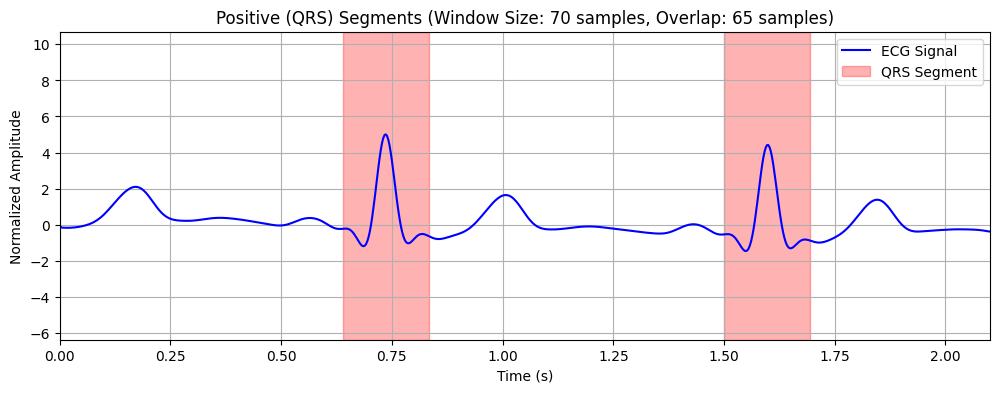

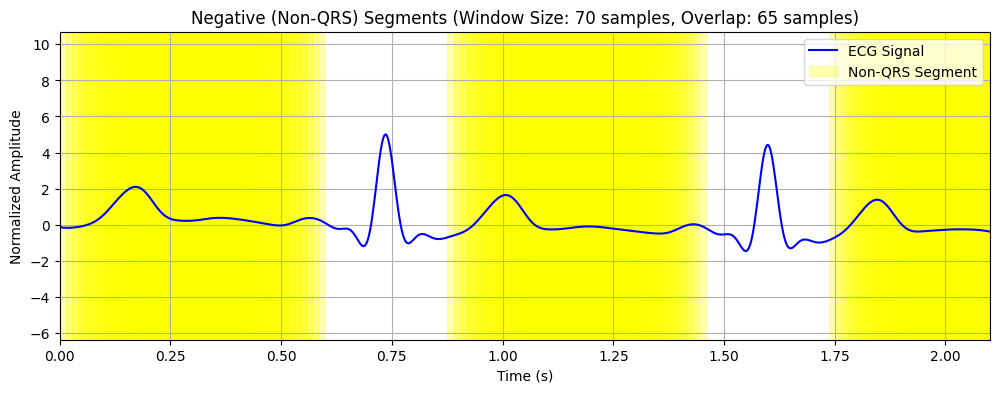

In [58]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)